In [71]:

import os
import requests
import sys
import gzip

import datetime
import time




import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [72]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

In [73]:
reg = 3
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)

In [90]:
df['Profil'].unique()

array(['ENT3 (+ ENT4 + ENT5)', 'PRO1 (+ PRO1WE)',
       'PRO2 (+ PRO2WE + PRO6)', 'PRO3', 'PRO4', 'PRO5',
       'RES1 (+ RES1WE)', 'RES11 (+ RES11WE)', 'RES2 (+ RES5)', 'RES2WE',
       'RES3', 'RES4'], dtype=object)

In [122]:
df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)'), 'Plage de puissance souscrite'].unique()

array(['P0: Total <= 36 kVA'], dtype=object)

In [123]:
#Analyse de la consommation en tant que série temporelle 
#sub_df = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P5: ]12-15] kVA')]

sub_df = df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)') & (df['Plage de puissance souscrite']=='P0: Total <= 36 kVA')]
valeurs = sub_df['Total énergie soutirée (Wh)'] / sub_df['Nb points soutirage']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d = {'date': date, 'consommation': valeurs}


serie = pd.DataFrame(d)
serie.set_index('date', inplace=True)
start_time = serie.index.min()
serie.index = ((serie.index - start_time).total_seconds() / 1800).astype(int)



#Analyse de la température moyenne en tant que série temporelle 
valeurs_T = sub_df['T_moyenne']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d_T = {'date': date, 'T_moyenne': valeurs_T}


serie_T = pd.DataFrame(d_T)
serie_T.set_index('date', inplace=True)
start_time = serie_T.index.min()
serie_T.index = ((serie_T.index - start_time).total_seconds() / 1800).astype(int)

D:\Temp\ipykernel_24456\4011065089.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
D:\Temp\ipykernel_24456\4011065089.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))


In [124]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 6*30*48
test_long = 48
serie_log_np = serie #['consommation']

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]
test = serie_annee.iloc[-test_long:]


In [125]:
from statsmodels.tsa.statespace import sarimax

sarima_conso = SARIMAX(train['consommation'],order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()

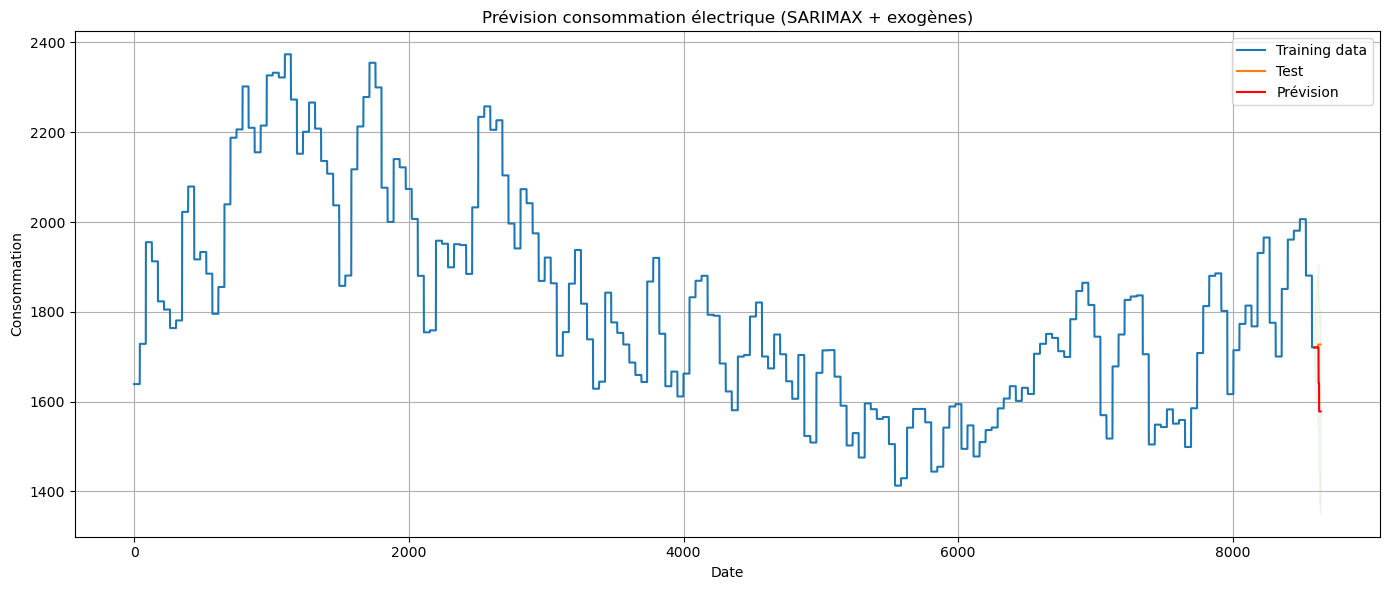

In [126]:
test = serie_annee.iloc[-test_long:]
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()


plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='g', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

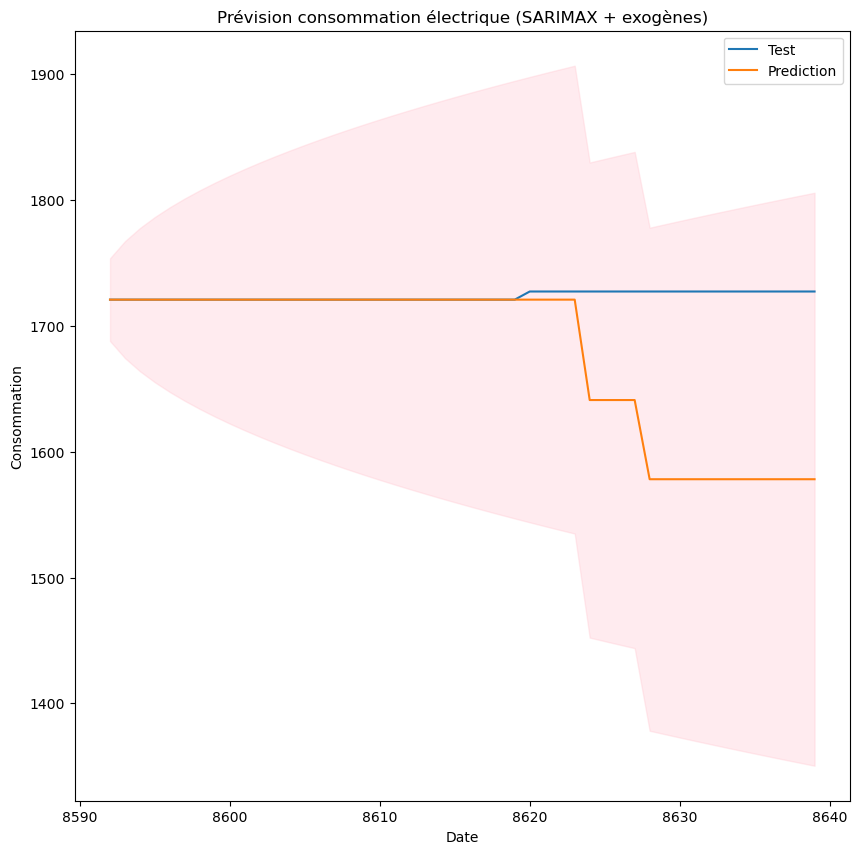

MAPE: 2.61%


In [127]:
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mape = mean_absolute_percentage_error(test, prediction)
print(f"MAPE: {mape:.2%}")

In [128]:
# Décomposition 

from statsmodels.tsa.seasonal import seasonal_decompose 
# Premier niveau de décomosition
decomposition_1 = seasonal_decompose(serie, period=48,  model='multiplicative', extrapolate_trend='freq') 
trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
resid_1 = decomposition_1.resid
# Deuxième niveau de décomosition

decomposition_2= seasonal_decompose(trend_1, period=48*7, model='multiplicative', extrapolate_trend='freq') #
trend_2 = decomposition_2.trend
seasonal_2 = decomposition_2.seasonal
resid_2 = decomposition_2.resid


# A prédire 
# Longueur séries 
forceast_long = 28*48
test_long = 48

X_1 =  seasonal_1.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,48)
X_2 =  trend_1.iloc[0: forceast_long]  #  RL par rapport à la 1/température  
X_3 =  resid_1.iloc[0: forceast_long]  # par SARIMAX (5,1,2)(1,1,0,14) 
#X_4 =  resid_1 .iloc[0: forceast_long]* resid_2.iloc[0: forceast_long]



In [129]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prediction de X_1

train_X_1 = X_1.iloc[0:(len(X_1)-test_long)]
test_X_1 =  X_1.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(train_X_1.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_1 = results_X_1.get_forecast(steps=len(test_X_1))
print("moyenne prediction ...")
prediction_X_1 = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()





modèle...
entrainement...
prediction...
moyenne prediction ...
IC...


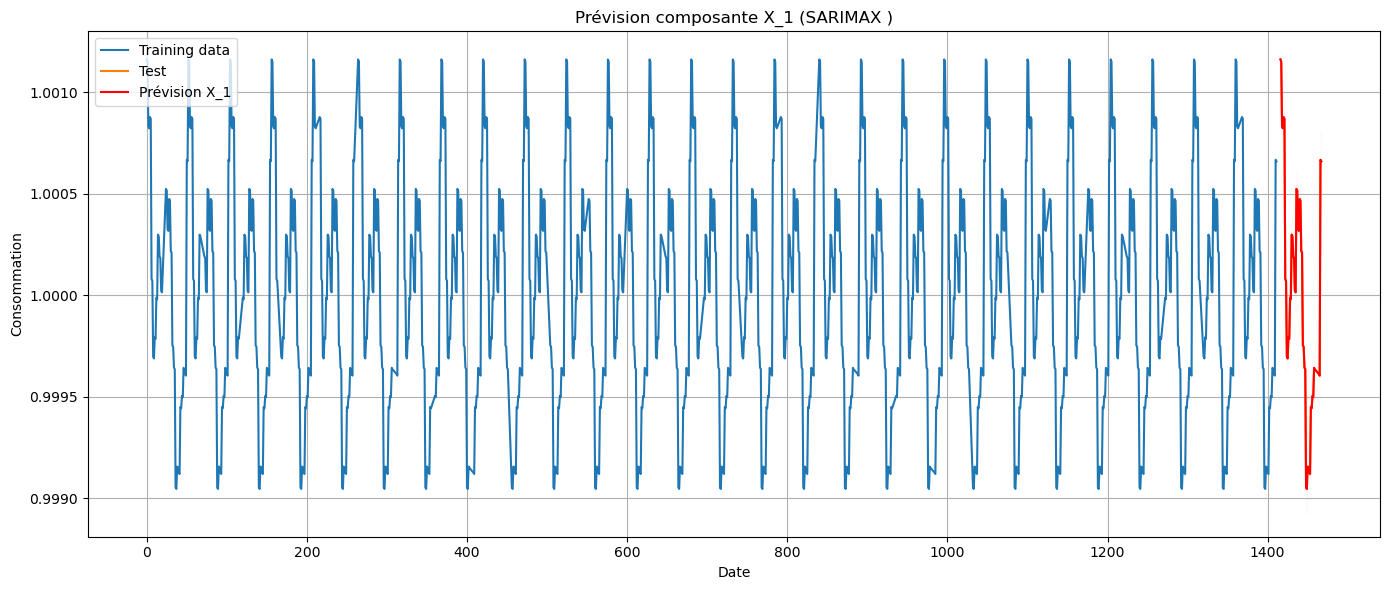

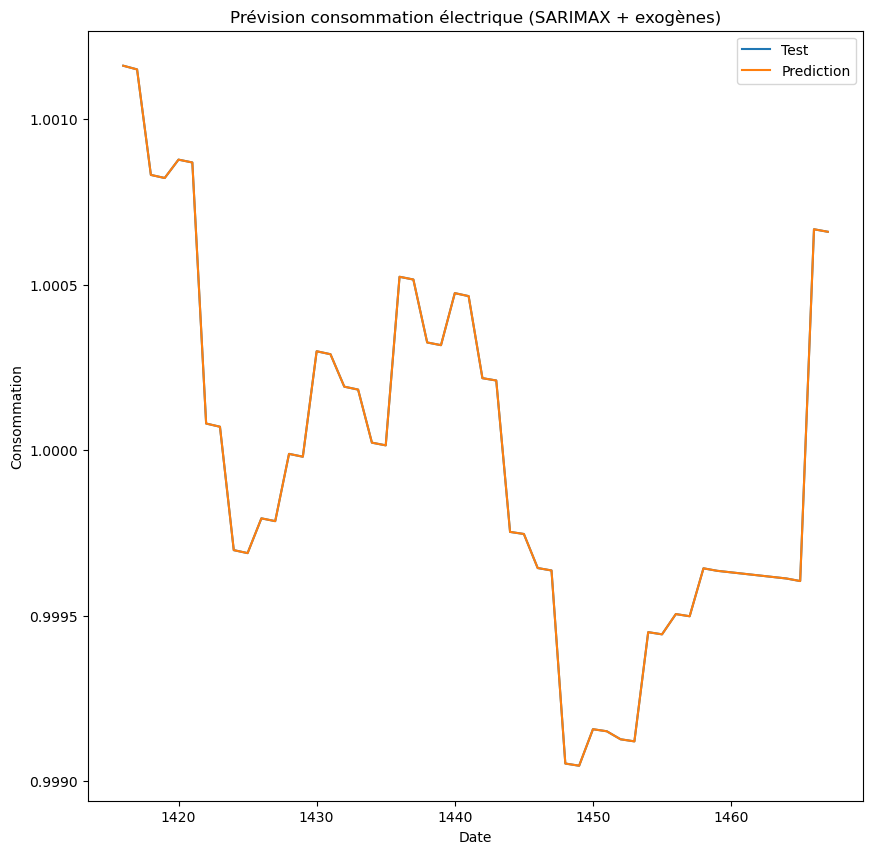

MAPE: 0.00%


In [130]:
# Visualisation pour X_1 

prediction_X_1 = pd.Series(prediction_X_1, index = test_X_1.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_1, label = 'Training data')
plt.plot(test_X_1, label ='Test')
plt.plot(prediction_X_1, label='Prévision X_1', color='red')
plt.fill_between(prediction_X_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_1, label ='Test')
plt.plot(prediction_X_1, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_1, prediction_X_1)
print(f"MAPE: {mape:.2%}")

In [131]:
len(test_X_3)

48

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction...
moyenne prediction ...
IC...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


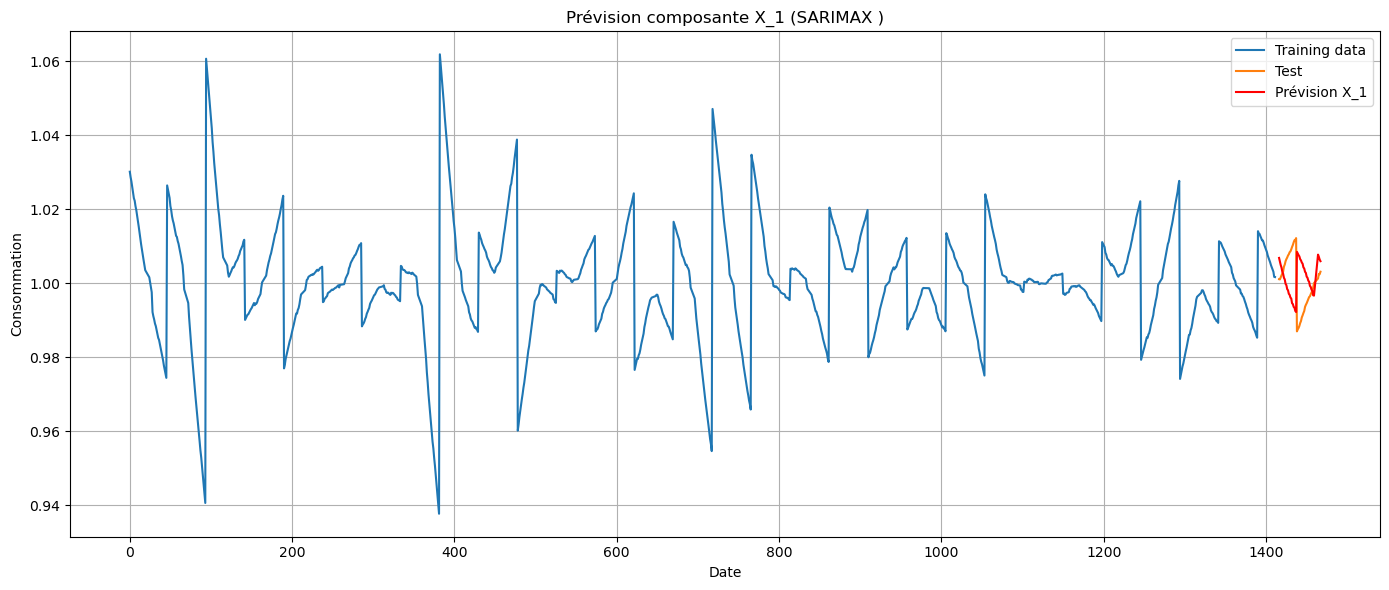

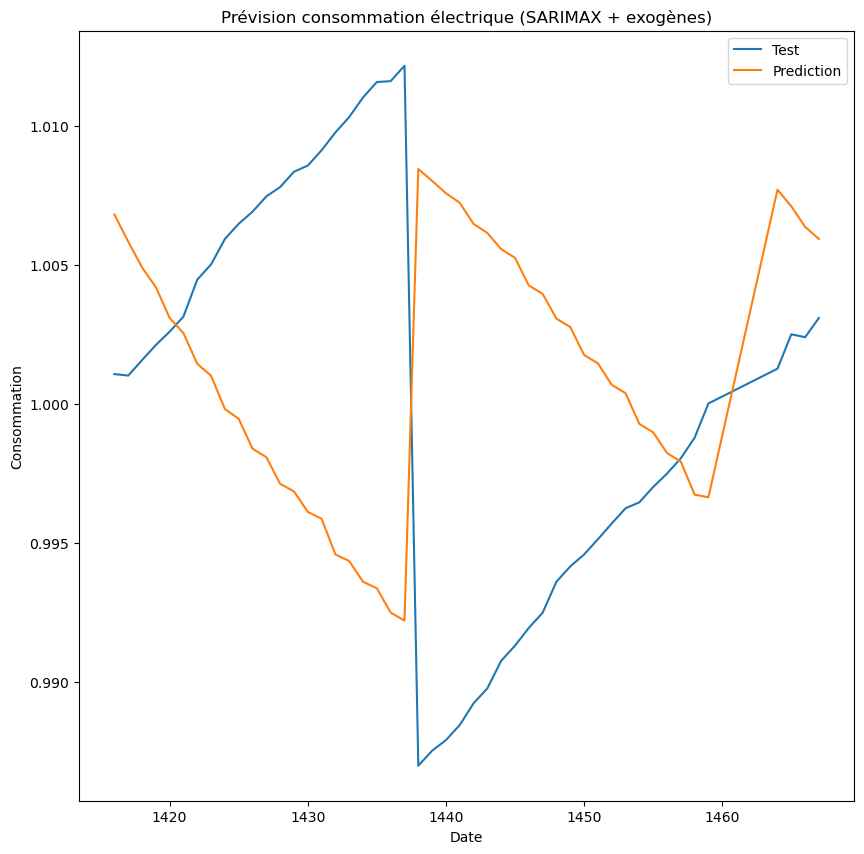

MAPE: 0.93%


In [132]:
# Prediction de resid_1


train_X_3 = X_3.iloc[0:(len(X_3)-test_long)]
test_X_3 =  X_3.iloc[-test_long:]



print("modèle...")

sarima_conso = SARIMAX(train_X_3,
                      order=(5,1,2),
                      seasonal_order=(1,1,1,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False,
                       disp=False)
                      
print("entrainement...")
results_X_3 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_3 = results_X_3.get_forecast(steps=len(test_X_3))
print("moyenne prediction ...")
prediction_X_3 = forecast_X_3.predicted_mean
print("IC...")
#conf_int = forecast_resid_1.conf_int()



# Affichage 
# Visualisation pour X_1 

prediction_X_3 = pd.Series(prediction_X_3.values, index = test_X_3.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_3, label = 'Training data')
plt.plot(test_X_3, label ='Test')
plt.plot(prediction_X_3, label='Prévision X_1', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_3, label ='Test')
plt.plot(prediction_X_3, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_3, prediction_X_3)
print(f"MAPE: {mape:.2%}")



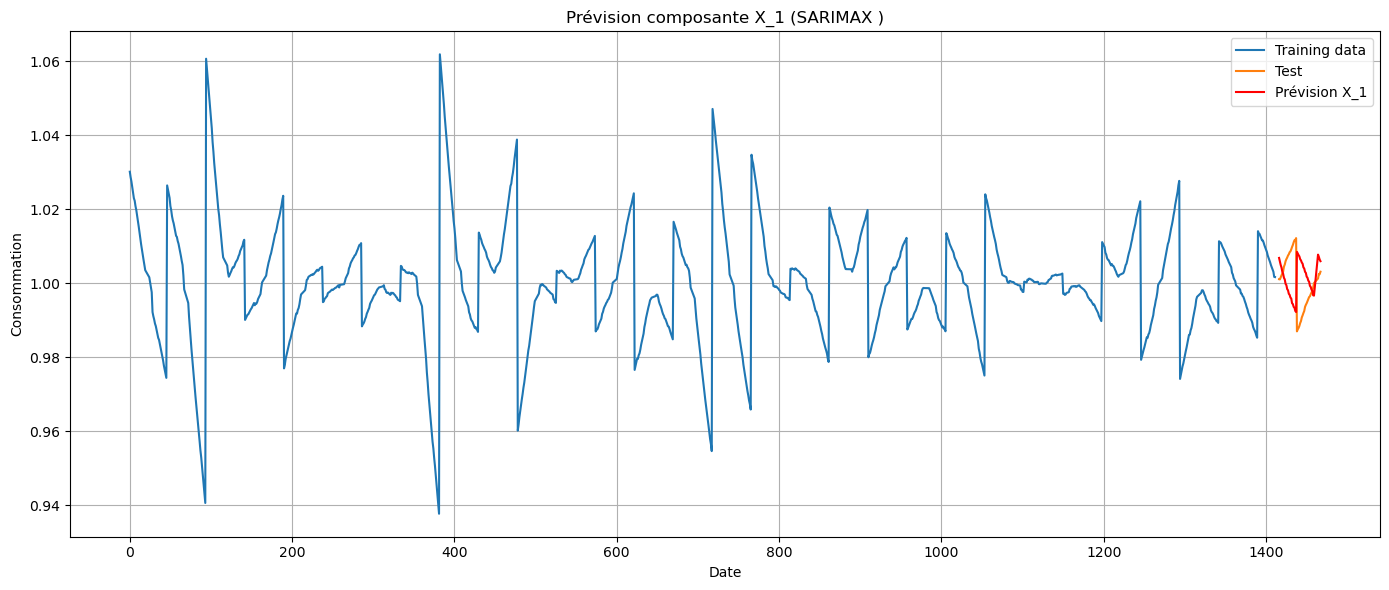

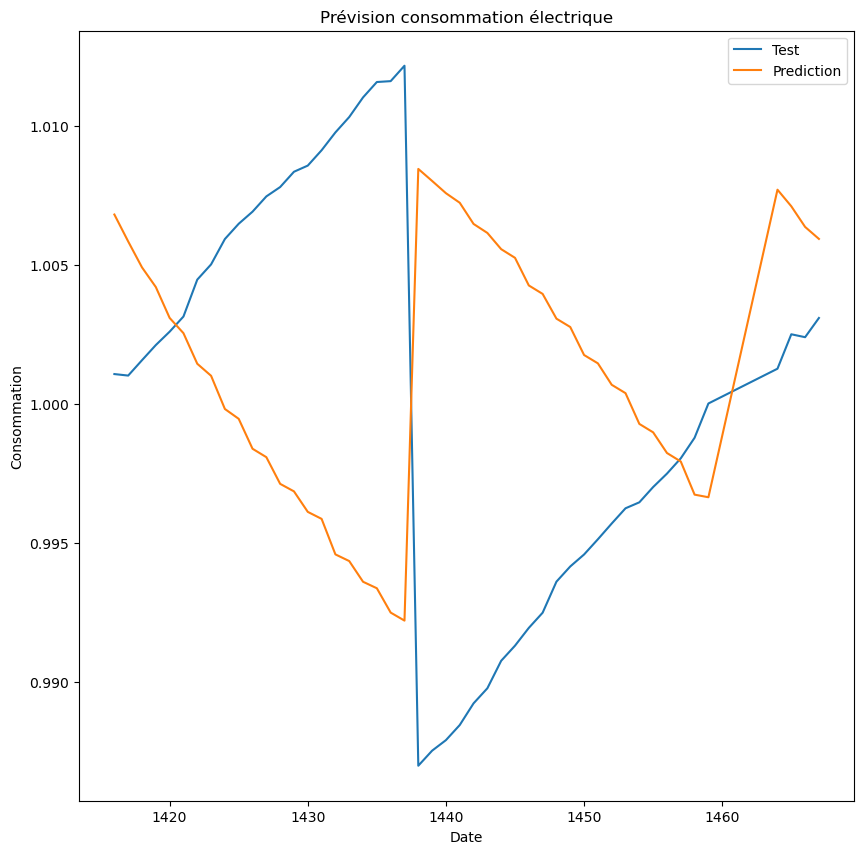

MAPE: 0.93%


In [133]:
prediction_resid_1 = pd.Series(prediction_X_3.values, index = test_X_3.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_3, label = 'Training data')
plt.plot(test_X_3, label ='Test')
plt.plot(prediction_resid_1, label='Prévision X_1', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_3, label ='Test')
plt.plot(prediction_resid_1, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_3, prediction_resid_1)
print(f"MAPE: {mape:.2%}")

In [134]:

# Prediction de X_2

train_X_2 = X_2.iloc[0:(len(X_2)-test_long)]
test_X_2 =  X_2.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(train_X_2.values,order=(1,1,0),
                      seasonal_order=(1,1,0,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_2 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_2 = results_X_2.get_forecast(steps=len(test_X_2))
print("moyenne prediction ...")
prediction_X_2 = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()

"""
print("modèle...")
estimator_X_2 = TBATS(seasonal_periods=(48*7,48))
model_X_2 = estimator_X_2.fit(train_X_2)# Forecast 365 days ahead
forecast_X_2 = model_X_2.forecast(steps=test_long)
"""

modèle...
entrainement...
prediction...
moyenne prediction ...
IC...


'\nprint("modèle...")\nestimator_X_2 = TBATS(seasonal_periods=(48*7,48))\nmodel_X_2 = estimator_X_2.fit(train_X_2)# Forecast 365 days ahead\nforecast_X_2 = model_X_2.forecast(steps=test_long)\n'

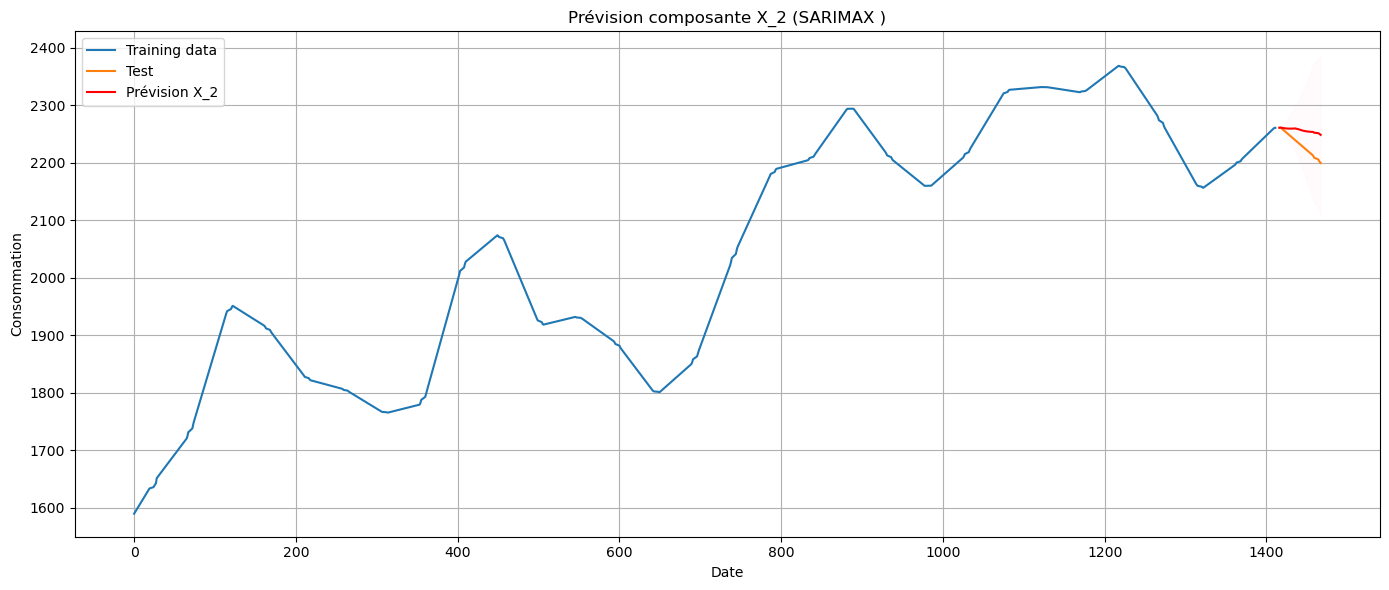

MAPE: 1.04%


In [135]:
# Visualisation pour X_2

prediction_X_2 = pd.Series(prediction_X_2, index = test_X_2.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_2, label = 'Training data')
plt.plot(test_X_2, label ='Test')
plt.plot(prediction_X_2, label='Prévision X_2', color='red')
plt.fill_between(prediction_X_2.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_2, label ='Test')
plt.plot(prediction_X_2, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_2, prediction_X_2)
print(f"MAPE: {mape:.2%}")

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# 🧮 Métriques

y_true = test_X_1*test_X_2*test_X_3
y_pred = prediction_X_1*prediction_X_2*prediction_resid_1
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

✅ MAE  = 34.69
✅ RMSE = 41.30
✅ MAPE = 1.56%


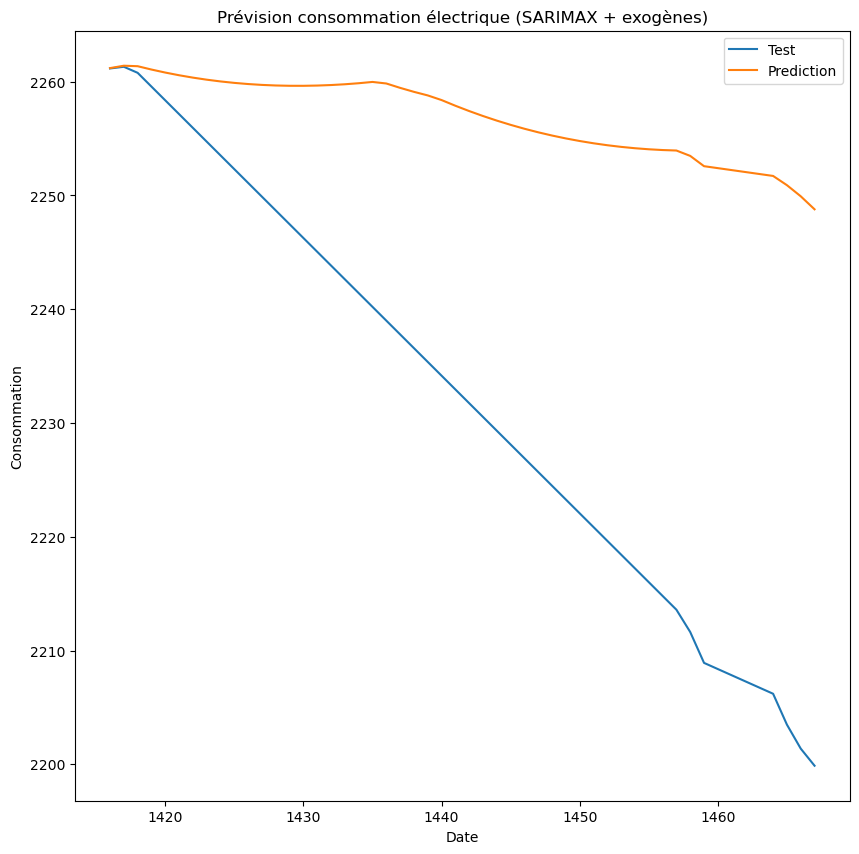

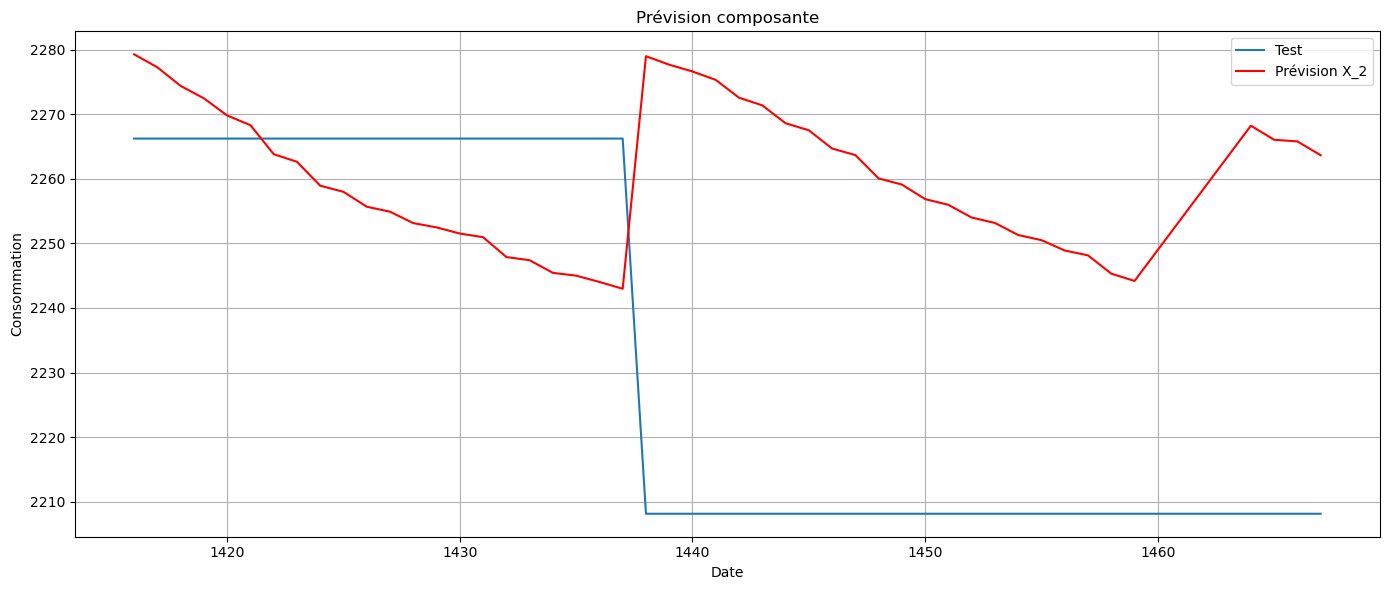

In [137]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label ='Test')
plt.plot(y_pred, label='Prévision X_2', color='red')
plt.title("Prévision composante")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()